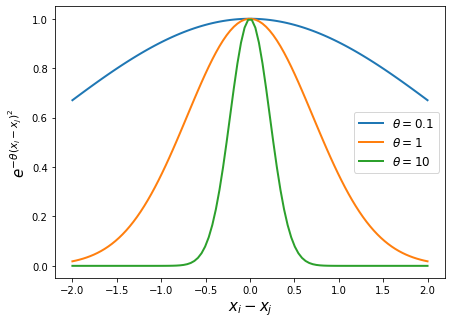

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.linalg import cho_solve
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

# Define parameter range and theta values
shift = np.linspace(-2, 2, 100)
thetas = np.array([0.1,1,10])

# Calculate correlation under various theta values
corrs = [np.exp(-theta*shift**2) for theta in thetas]

# Visualize results
fig, ax = plt.subplots(figsize=(7,5))

# Define labels
labels = [r'$\theta=0.1$', r'$\theta=1$', r'$\theta=10$']

for i in range(thetas.shape[0]):
    ax.plot(shift, corrs[i], label=labels[i], lw=2)
ax.legend(fontsize=12)
ax.set_xlabel(r'$x_i-x_j$', fontsize=15)
ax.set_ylabel(r'$e^{-\theta (x_i-x_j)^2}$', fontsize=15)
plt.savefig('theta_value_gp.png')

In [6]:
class GaussianProcess:
    """A Gaussian Process class that trains and exploits 
    a Gaussian Process model"""
    
    def __init__(self, n_restarts, optimizer):
        """Initialize a Gaussian Process model
        
        Input
        ------
        n_restarts: number of restarts of the local optimizer
        optimizer: algorithm of local optimization"""
        
        self.n_restarts = n_restarts
        self.optimizer = optimizer
        
       
    def Corr(self, X1, X2, theta):
        """Construct the correlation matrix between X1 and X2
        
        Input
        -----
        X1, X2: 2D arrays, shape (n_samples, n_features)
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        K: the correlation matrix
        """
        K = np.zeros((X1.shape[0], X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
            
        return K
 
       
    def Neglikelihood(self, theta):
        """Negative likelihood function
        
        Input
        -----
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        LnLike: likelihood value"""
        
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = self.Corr(self.X, self.X, theta) + np.eye(n)*1e-10
        L = np.linalg.cholesky(K)
        #inv_K = np.linalg.inv(K)   # Inverse of correlation matrix
        
        # Mean estimation
        mu = (one.T @ (cho_solve((L, True), self.y))) / \
            (one.T @ (cho_solve((L, True), one)))
        # mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ (cho_solve((L, True), self.y-mu*one)) / n
        # SigmaSqr = (self.y-mu*one).T @ inv_K @ (self.y-mu*one) / n
        
        # Compute log-likelihood
        LnDetK = 2*np.sum(np.log(np.abs(np.diag(L))))
        # DetK = np.linalg.det(K)
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*LnDetK
        
        # Update attributes
        self.K, self.L, self.mu, self.SigmaSqr = K, L, mu, SigmaSqr
        
        return -LnLike.flatten()
        
        
    def fit(self, X, y):
        """GP model training
        
        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """
        
        self.X, self.y = X, y
        lb, ub = -3, 2
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        
        # Scale random samples to the given bounds 
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))
        
        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i,:], method=self.optimizer,
                bounds=bnds)
            opt_para[i,:] = res.x
            opt_func[i,:] = res.fun
        
        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]
        
        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)
        
    
    def predict(self, X_test):
        """GP model predicting
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        
        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""
        
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        k = self.Corr(self.X, X_test, 10**self.theta)
        
        # Mean prediction
        f = self.mu + k.T @ (cho_solve((self.L, True), self.y-self.mu*one))
        # f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ (cho_solve((self.L, True), k))))
        # SSqr = self.SigmaSqr*(1 - np.diag(k.T @ self.inv_K @ k))
        
        return f.flatten(), SSqr.flatten()
    
    def score(self, X_test, y_test):
        """Calculate root mean squared error
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        y_test: test labels, array of shape (n_samples, )
        
        Output
        ------
        RMSE: the root mean square error"""
        
        y_pred, SSqr = self.predict(X_test)
        RMSE = np.sqrt(np.mean((y_pred-y_test)**2))
        
        return RMSE

In [8]:
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

(-10, 20)

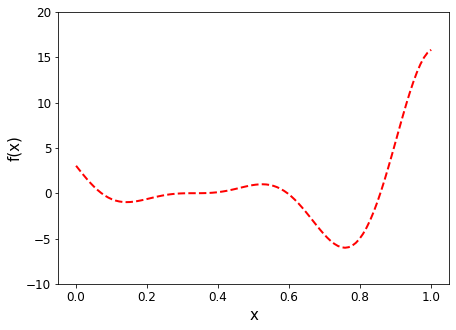

In [9]:
# Display the function to be approximated
fig, ax = plt.subplots(figsize=(7,5))

X = np.linspace(0.0, 1, 100).reshape(-1,1)
y = Test_1D(X)

ax.plot(X, y,'r--', lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])

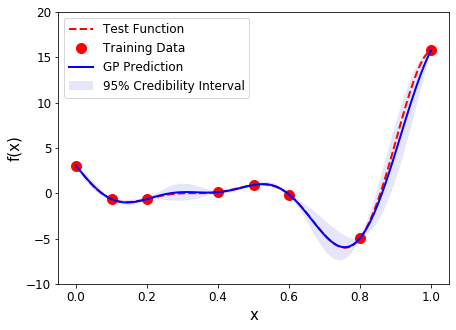

In [10]:
# Training data
X_train = np.array([0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]).reshape(-1,1)
y_train = Test_1D(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

# GP model training
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12})

# Ejemplo con la de scikit 
## Sacado de (https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)

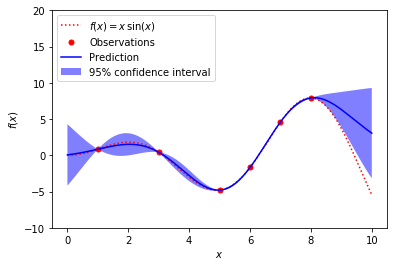

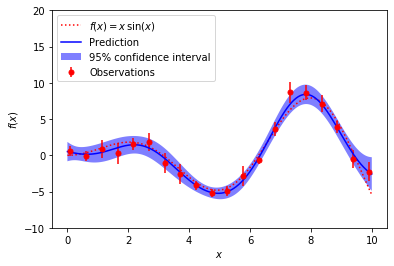

In [2]:
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>s
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)


# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1.0, 3.0, 5.0, 6.0, 7.0, 8.0]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), "r:", label=r"$f(x) = x\,\sin(x)$")
plt.plot(X, y, "r.", markersize=10, label="Observations")
plt.plot(x, y_pred, "b-", label="Prediction")
plt.fill(
    np.concatenate([x, x[::-1]]),
    np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
    alpha=0.5,
    fc="b",
    ec="None",
    label="95% confidence interval",
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 20)
plt.legend(loc="upper left")

# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), "r:", label=r"$f(x) = x\,\sin(x)$")
plt.errorbar(X.ravel(), y, dy, fmt="r.", markersize=10, label="Observations")
plt.plot(x, y_pred, "b-", label="Prediction")
plt.fill(
    np.concatenate([x, x[::-1]]),
    np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
    alpha=0.5,
    fc="b",
    ec="None",
    label="95% confidence interval",
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 20)
plt.legend(loc="upper left")

plt.show()

In [11]:
print(y_pred)

[ 5.16414418e-01  5.06761088e-01  4.97164221e-01  4.87627288e-01
  4.78153758e-01  4.68747097e-01  4.59410769e-01  4.50148231e-01
  4.40962936e-01  4.31858327e-01  4.22837839e-01  4.13904897e-01
  4.05062914e-01  3.96315290e-01  3.87665411e-01  3.79116646e-01
  3.70672347e-01  3.62335850e-01  3.54110469e-01  3.45999496e-01
  3.38006202e-01  3.30133834e-01  3.22385612e-01  3.14764730e-01
  3.07274356e-01  2.99917626e-01  2.92697645e-01  2.85617487e-01
  2.78680193e-01  2.71888766e-01  2.65246176e-01  2.58755355e-01
  2.52419192e-01  2.46240541e-01  2.40222212e-01  2.34366970e-01
  2.28677538e-01  2.23156594e-01  2.17806767e-01  2.12630638e-01
  2.07630740e-01  2.02809554e-01  1.98169509e-01  1.93712980e-01
  1.89442289e-01  1.85359701e-01  1.81467425e-01  1.77767611e-01
  1.74262349e-01  1.70953671e-01  1.67843545e-01  1.64933876e-01
  1.62226507e-01  1.59723214e-01  1.57425710e-01  1.55335636e-01
  1.53454569e-01  1.51784016e-01  1.50325412e-01  1.49080123e-01
  1.48049441e-01  1.47234

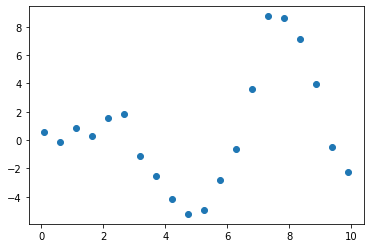

In [6]:
plt.scatter(X,y)

[[0.        ]
 [0.003003  ]
 [0.00600601]
 [0.00900901]
 [0.01201201]
 [0.01501502]
 [0.01801802]
 [0.02102102]
 [0.02402402]
 [0.02702703]
 [0.03003003]
 [0.03303303]
 [0.03603604]
 [0.03903904]
 [0.04204204]
 [0.04504505]
 [0.04804805]
 [0.05105105]
 [0.05405405]
 [0.05705706]
 [0.06006006]
 [0.06306306]
 [0.06606607]
 [0.06906907]
 [0.07207207]
 [0.07507508]
 [0.07807808]
 [0.08108108]
 [0.08408408]
 [0.08708709]
 [0.09009009]
 [0.09309309]
 [0.0960961 ]
 [0.0990991 ]
 [0.1021021 ]
 [0.10510511]
 [0.10810811]
 [0.11111111]
 [0.11411411]
 [0.11711712]
 [0.12012012]
 [0.12312312]
 [0.12612613]
 [0.12912913]
 [0.13213213]
 [0.13513514]
 [0.13813814]
 [0.14114114]
 [0.14414414]
 [0.14714715]
 [0.15015015]
 [0.15315315]
 [0.15615616]
 [0.15915916]
 [0.16216216]
 [0.16516517]
 [0.16816817]
 [0.17117117]
 [0.17417417]
 [0.17717718]
 [0.18018018]
 [0.18318318]
 [0.18618619]
 [0.18918919]
 [0.19219219]
 [0.1951952 ]
 [0.1981982 ]
 [0.2012012 ]
 [0.2042042 ]
 [0.20720721]
 [0.21021021]
 [0.21

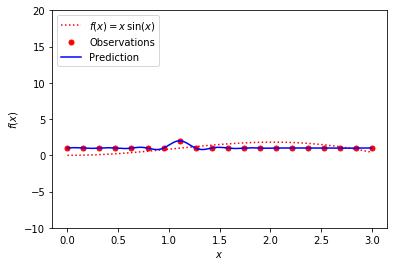

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


def f(x):
    return x * np.sin(x)

X = np.atleast_2d(np.linspace(0.0,3.0,20)).T
y = [1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1]

x = np.atleast_2d(np.linspace(0, 3, 1000)).T


kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

y_pred = gp.predict(x)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), "r:", label=r"$f(x) = x\,\sin(x)$")
plt.plot(X, y, "r.", markersize=10, label="Observations")
plt.plot(x, y_pred, "b-", label="Prediction")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 20)
plt.legend(loc="upper left")
print(x)

array([ 0.        ,  0.26439534,  0.91445223,  1.57889492,  1.81166387,
        1.28470844, -0.05147798, -1.90245116, -3.69131803, -4.73542597,
       -4.48485457, -2.74361725,  0.20588457,  3.62816874,  6.51673078,
        7.88818122,  7.10297217,  4.11113598, -0.46313769, -5.44021111])

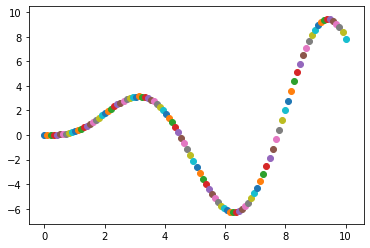

In [74]:
from scipy.integrate import quad

def integral(x1):
    return quad(lambda b: gp.predict([[b]]), 0.0, x1 )[0]

arreglo = np.linspace(0.0,10.0,100)

for ii in range(len(arreglo)):
    plt.scatter(arreglo[ii], integral(arreglo[ii]))
y

In [579]:
#EoS with a Gaussian Process as explained in https://arxiv.org/pdf/1902.09423.pdf

import math as N
import numpy as np
from LCDMCosmology import *
from scipy.integrate import quad
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from ParamDefs import *
class eos_gaussian_process(LCDMCosmology):
    def __init__(self):

        self.parvals = zbin_eos_par
        self.zs = [i.value for i in self.parvals]
        names   = [i.name  for i in self.parvals]
        self.index = dict((j,i) for i,j in enumerate(names))

        LCDMCosmology.__init__(self)

    def freeParameters(self):
        l = LCDMCosmology.freeParameters(self)
        l+= self.parvals
        return l

    def updateParams(self, pars):
        ok = LCDMCosmology.updateParams(self, pars)
        if not ok:
            return False
        for p in pars:
            for i in range(len(self.parvals)):
                if p.name == ("zbin_eos"+str(i)):
                    self.zs[i] = p.value
        return True

    def luisfunction(self, z):
        w_i = self.zs
        z_i = np.atleast_2d(np.linspace(0.0,3.0,len(self.parvals))).T
        kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        gp.fit(z_i, w_i)
        if 0.0<=z<=3.0:
            resultado = quad(lambda b: 3.0*(1.0+gp.predict([[b]]))/(1.0+b), 0.0, z)
        elif z>3.0:
            resultado = [-1.0,1.0]
        return luisfunction2(z), resultado[0]

    def RHSquared_a(self,a):
        NuContrib=self.NuDensity.rho(a)/self.h**2
        z= 1./a - 1
        return (self.Ocb/a**3+self.Omrad/a**4+NuContrib+(1.0-self.Om)*(np.exp(self.luisfunction(z)[1])) )




ModuleNotFoundError: No module named 'LCDMCosmology'

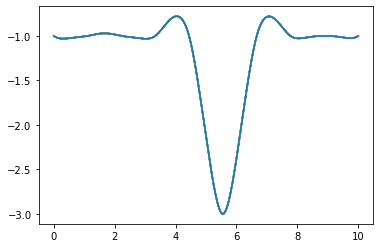

In [589]:
w_i = np.array([-1,-1,-1,-1,-1,-3.,-1,-1,-1,-1])
z_i = np.atleast_2d(np.linspace(0.0,10.0,10)).T

z_i_pred = np.atleast_2d(np.linspace(0.0,10.0,1000)).T

#kernel = C(1, (1e-3, 1e3)) * RBF(10, (1e-5, 1e5))
#kernel = RBF(10, (1e-2, 1e2))
kernel = Matern(1, nu=1.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
#gp.fit(z_i, w_i)
for ii in range(10):
    gp.fit(z_i, w_i)
    resultado = quad(lambda b: 3.0*(1.0+gp.predict([[b]]))/(1.0+b), 0.0, 3.0)[0]
    plt.plot(z_i_pred, gp.predict(z_i_pred))
    #print(gp.predict([[2.0]]))

plt.plot(z_i_pred, gp.predict(z_i_pred))

In [590]:
type(w_i)

numpy.ndarray